In [2]:
# %cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

# !git config --global user.email 'intaek428@gmail.com'
# !git config --global user.name 'ITHwang'

# !git add .
# !git commit -m ''
# !git push

!pip install -Uqq fastbook

import fastbook
from fastai.vision.all import *

     |████████████████████████████████| 720 kB 12.2 MB/s 
     |████████████████████████████████| 189 kB 45.5 MB/s 
     |████████████████████████████████| 1.2 MB 43.7 MB/s 
     |████████████████████████████████| 48 kB 5.4 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 318 kB/s 
     |████████████████████████████████| 558 kB 42.4 MB/s 
     |████████████████████████████████| 130 kB 48.6 MB/s 


In [2]:
path = untar_data(URLs.PASCAL_2007)

In [3]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train')]

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
dblock = DataBlock()

In [6]:
dsets = dblock.datasets(df)

In [7]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [8]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [9]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[10]

(Path('/root/.fastai/data/pascal_2007/train/006046.jpg'), ['boat'])

In [10]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [11]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['train']

In [12]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [13]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

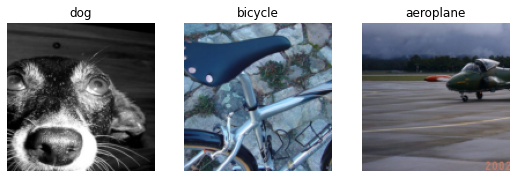

In [15]:
dls.show_batch(nrows=1, ncols=3)

In [16]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

RuntimeError: ignored

In [18]:
activs[0]

NameError: ignored

In [19]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [20]:
def accuracy(inp, targ, axis=-1):
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

In [21]:
def accuracy(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp > thresh)==targ.bool()).float().mean()

In [22]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.939170,0.703148,0.232649,00:45


KeyboardInterrupt: ignored

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/20'),Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/07.obj'),Path('/root/.fastai/data/biwi_head_pose/05.obj'),Path('/root/.fastai/data/biwi_head_pose/19.obj'),Path('/root/.fastai/data/biwi_head_pose/18'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/20.obj'),Path('/root/.fastai/data/biwi_head_pose/09')...]

In [4]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00387_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00377_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00376_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00205_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00418_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00213_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00029_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00266_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00187_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00016_rgb.jpg')...]

In [5]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/20/frame_00376_pose.txt')

In [6]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

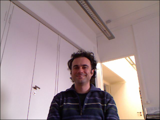

In [7]:
im.to_thumb(160)

In [8]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [9]:
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

In [10]:
get_ctr(img_files[0])

tensor([343.6100, 277.0679])

In [11]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240, 320)),
                Normalize.from_stats(*imagenet_stats)]
)

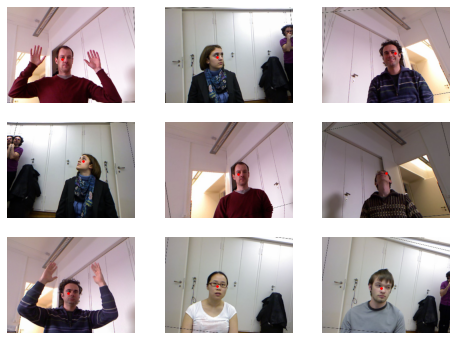

In [14]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [15]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [17]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  


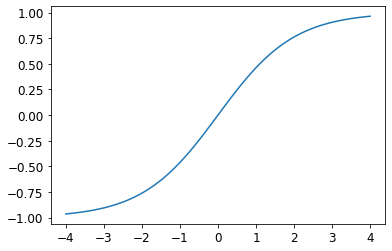

In [18]:
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [19]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0020892962347716093)

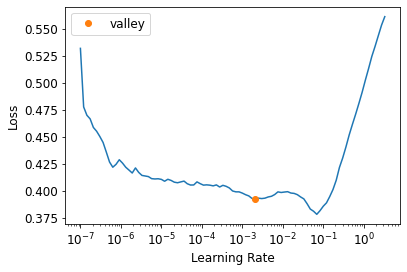

In [20]:
learn.lr_find()

In [21]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.046572,0.003854,03:59


epoch,train_loss,valid_loss,time
0,0.007244,0.001383,05:21
1,0.003156,0.000517,05:10
2,0.001455,0.000068,05:09


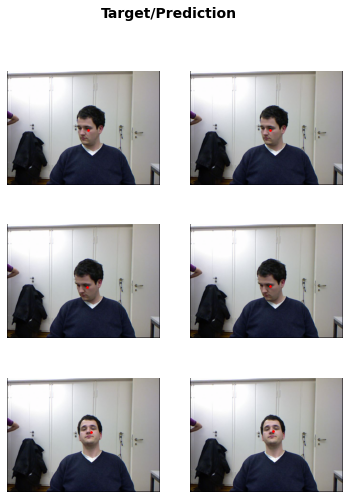

In [22]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

!git config --global user.email 'intaek428@gmail.com'
!git config --global user.name 'ITHwang'

!git add .
!git commit -m ''
!git push